# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [22]:
from __future__ import print_function, division
%matplotlib inline

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [24]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [25]:
print('Number of instances: {}, number of attributes: {}'.format(X.shape[0], X.shape[1]))
print('Number of instances: {}'.format(y.shape))
print(X.describe())
print(y)

Number of instances: 2845, number of attributes: 1000
Number of instances: (2845L,)
               abc      ability         able           ac       accept  \
count  2845.000000  2845.000000  2845.000000  2845.000000  2845.000000   
mean      0.002436     0.002144     0.006710     0.001454     0.002285   
std       0.030224     0.020707     0.034655     0.023100     0.021627   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.723914     0.420916     0.431380     0.519765     0.443354   

            access    according     acquired     actually      adaptec  \
count  2845.000000  2845.000000  2845.000000  2845.000000  2845.000000   
mean      0.003945     0.003125     0.000920     0.008367     0.001806   
std       0.030010     0.02

X represents 2845 documents, and each row of X is document and each column of X is the tf-idf weights. y is an array of labels respect to the documents in X.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [26]:
kmeans = KMeans(n_clusters=5, random_state=1337)  
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1337, tol=0.0001,
    verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [27]:
avg = X.mean(axis=0).as_matrix()
distances = []
for index, row in X.iterrows():
    distances.append(LA.norm(row - mean))
mean_distance = np.mean(distances)

In [28]:
print("the mean distance is :",mean_distance)
print ("the inertia and the adjusted_rand_score is:",kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_))

the mean distance is : 0.954581397358
the inertia and the adjusted_rand_score is: 2593.17430766 0.216104350793


1.The inertia is the sum of distances that samples to their closest cluster center, so the lower, the better. 
  The adjusted rand score is to measure how simliarly two class are. 
2.the quality of the clustering is not very good, since the inertia is high and adjusted rand score is low. 

### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [49]:
labels = y.tolist()
num_data = dict((x,labels.count(x)) for x in set(labels))
print ('Number of datapoints with each label: ', num_data)
clusters = kmeans.labels_.tolist()
cluster_datapoints = dict((x,clusters.count(x)) for x in set(clusters))
print ('Number of datapoints assigned to each cluster: ', cluster_datapoints)

Number of datapoints with each label:  {'comp.sys.ibm.pc.hardware': 590, 'comp.sys.mac.hardware': 578, 'rec.sport.hockey': 600, 'rec.sport.baseball': 597, 'alt.atheism': 480}
Number of datapoints assigned to each cluster:  {0: 1050, 1: 570, 2: 649, 3: 233, 4: 343}


The number of datapoints assigned to each cluster have a huge differenece than the number of datapoints assigned to each label, the reason could make this happen might be some of the datapoints are pretty similar, so in unsupervised learning, it is assgined to the most likely cluster. 


### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [50]:
cluster_centers=kmeans.cluster_centers_
center_distance=np.zeros((5,5))
for i in range(5):
    for j in range(5):
        center_distance[i,j]=LA.norm(cluster_centers[i]-cluster_centers[j])
print(center_distance)

[[ 0.          0.19481871  0.20336322  0.33095496  0.22738455]
 [ 0.19481871  0.          0.29223799  0.32040898  0.29210539]
 [ 0.20336322  0.29223799  0.          0.39748207  0.28369637]
 [ 0.33095496  0.32040898  0.39748207  0.          0.39922129]
 [ 0.22738455  0.29210539  0.28369637  0.39922129  0.        ]]


### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

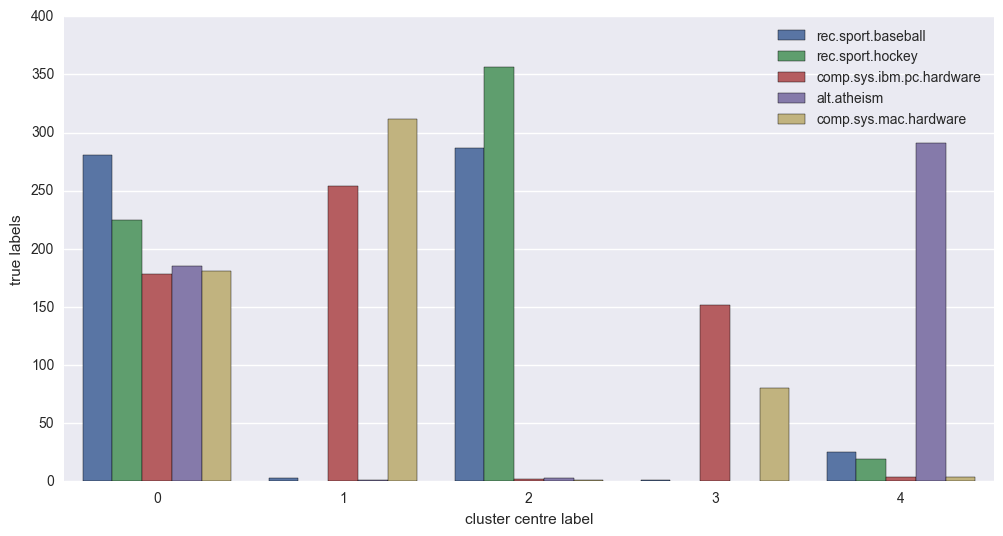

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(x=kmeans.labels_, hue=y)
plt.xlabel('cluster centre label')
plt.ylabel('true labels')
plt.show()

The fit we applied did not work well, we can not find a true label for the most of the cluster. The only true label we could find is in cluster 4, which is alt.atheism.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

Inertia is: 2.82109066477 adjusted_rand_score is: 0.209466028491
Inertia is: 10.592280453 adjusted_rand_score is: 0.268079336483
Inertia is: 20.4235331658 adjusted_rand_score is: 0.239479218068
Inertia is: 49.8674692394 adjusted_rand_score is: 0.2288985833
Inertia is: 118.178301295 adjusted_rand_score is: 0.213854607491
Inertia is: 231.905790868 adjusted_rand_score is: 0.209500299493
Inertia is: 492.377897319 adjusted_rand_score is: 0.207798369276
Inertia is: 820.096306441 adjusted_rand_score is: 0.225048950168
Inertia is: 2145.62769513 adjusted_rand_score is: 0.205869464934
Inertia is: 2593.16646207 adjusted_rand_score is: 0.231640388002


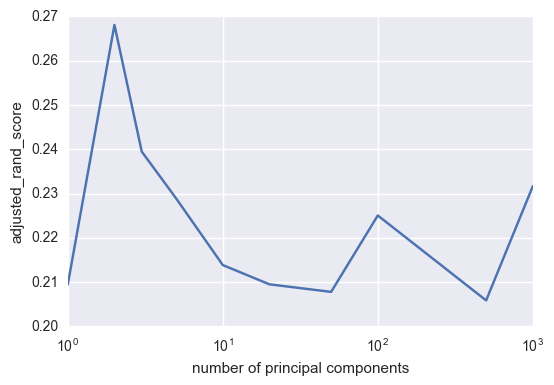

In [63]:
n_components = [1,2,3,5,10,20,50,100,500,1000] 
adjust=[]
for d in n_components:
    pca=PCA(n_components=d)
    Xlowdim=pca.fit_transform(X)
    kmeans_low=KMeans(n_clusters=5,random_state=1337)
    kmeans_low.fit(Xlowdim)
    adjust.append(adjusted_rand_score(y,kmeans_low.labels_))
    print('Inertia is:',kmeans_low.inertia_,'adjusted_rand_score is:',adjusted_rand_score(y,kmeans_low.labels_))
plt.figure()
plt.semilogx(n_components, adjust, basex=10)
plt.legend(loc=0)
plt.xlabel('number of principal components')
plt.ylabel('adjusted_rand_score')# ax_1.set_xlabel('number of principal compoents')
# ax_1.set_xscale('log')
# ax_1.set_ylabel('adjusted_rand_score')

1. the graph shows that the numer of principal components have a great affect on the adjusted_rand_score. When the number of principal components is between 10^0 and 10^1, it reaches the highest adjusted_rand_score.
2.Inertia is affected by the number of principla components.When we use lower dimensiona, it will get lower inertia, so we cant use inertia. 
3.The data is pretty sparse when it has high dimension, it is hard to say which cluster it belongs to and it potentially place the data in wrong cluster. When we use dimensionality reduction, the ways the datapoints could perform become less, so it is easier to label them with right clusters. 


### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

The adjusted rand score:  0.268079336483


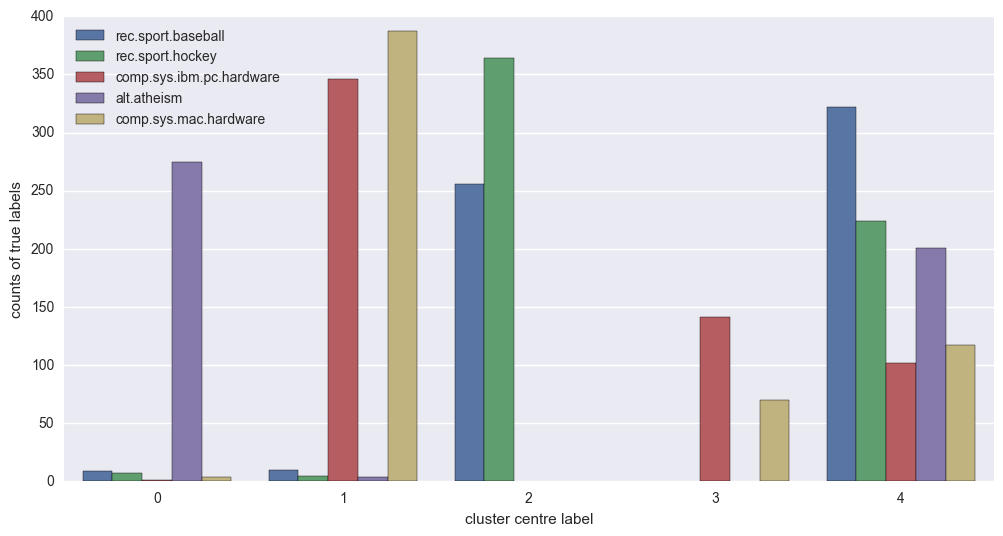

Number of data points each cluster is responsible for:  {0: 296, 1: 752, 2: 620, 3: 211, 4: 966}


In [66]:
#1.
X_2d = PCA(n_components=2).fit_transform(X)
#2.
kmeans_pca = KMeans(n_clusters=5, random_state=1337).fit(X_2d)
print ('The adjusted rand score: ', adjusted_rand_score(y, kmeans_pca.labels_))
#3.
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y)
plt.legend(loc=0)
plt.xlabel('cluster centre label')
plt.ylabel('counts of true labels')
plt.show()

clusters_pca = kmeans_pca.labels_.tolist()
cluster_datapoints_pca = dict((x,clusters_pca.count(x)) for x in set(clusters_pca))
print ('Number of data points each cluster is responsible for: ', cluster_datapoints_pca)

Although it has a better adjusted_rand_score and perform a little bit better than 100 dimensionality, it is still hard to distinguish which datapoints belong to a specific cluster. alt.athesim is still the only one that clearyly belong to label 0. 

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [70]:
labels_19 = ['alt.atheism', 'comp.sys.mac.hardware', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware','rec.sport.baseball']
labels_interp = []
for i in kmeans_pca.labels_:
    labels_interp.append(columns[i])
labels_interp = np.asarray(labels_interp)
labels_interp

array(['rec.sport.baseball', 'rec.sport.hockey', 'rec.sport.hockey', ...,
       'comp.sys.ibm.pc.hardware', 'rec.sport.hockey', 'rec.sport.baseball'], 
      dtype='|S24')

### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

In [68]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

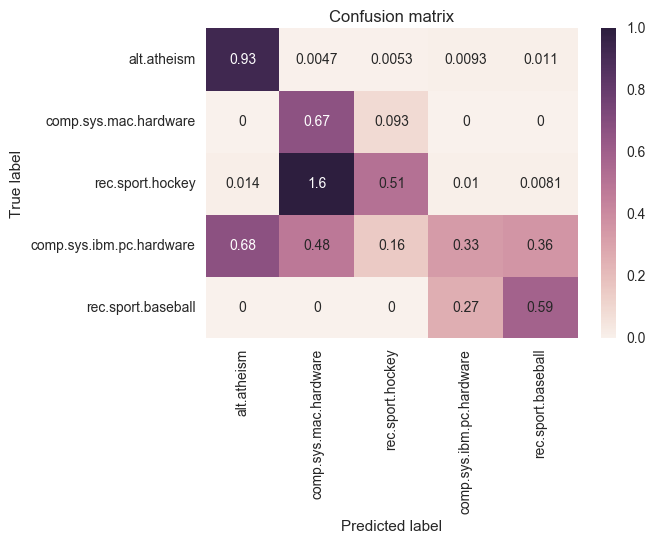

In [71]:
cm=confusion_matrix(labels_interp,y)
cm_norm = cm / cm.sum(axis=1)
plt.figure()
plot_confusion_matrix(cm_norm, classes=labels_19)

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

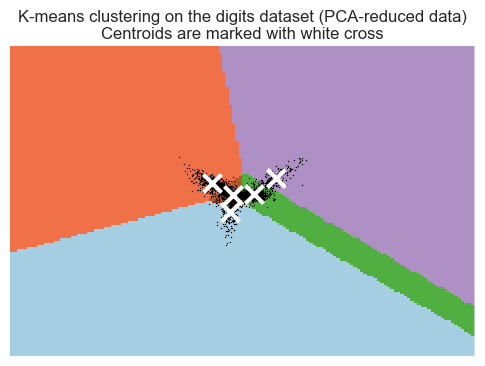

In [73]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_2d[:, 0], X_2d[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

C:\Users\damon\Anaconda2\envs\iaml\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\damon\Anaconda2\envs\iaml\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
C:\Users\damon\Anaconda2\envs\iaml\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\damon\Anaconda2\envs\iaml\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


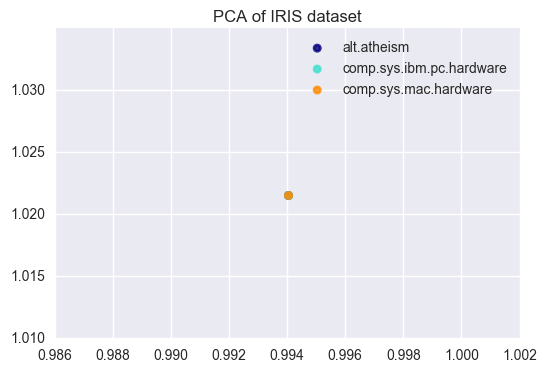

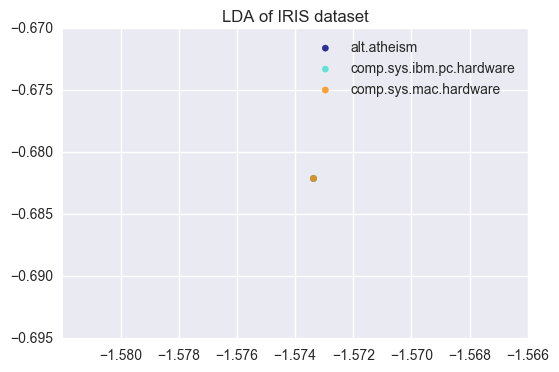

In [76]:
target_names = newsgroups_train.target_names
X_r = kmeans_pca.fit(X).transform(X)
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.1 do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [77]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [84]:
data_frame_digits = pd.DataFrame(digits.data)
des_data_frame_digits=data_frame_digits.describe()
data_frame_digits.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [91]:
print(des_data_frame_digits.iloc[[3]])

des_data_frame_digits.iloc[[7]]

      0    1    2    3    4    5    6    7    8    9  ...    54   55   56  \
min  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   

      57   58   59   60   61   62   63  
min  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 64 columns]


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
max,0.0,8.0,16.0,16.0,16.0,16.0,16.0,15.0,2.0,16.0,...,16.0,13.0,1.0,9.0,16.0,16.0,16.0,16.0,16.0,16.0


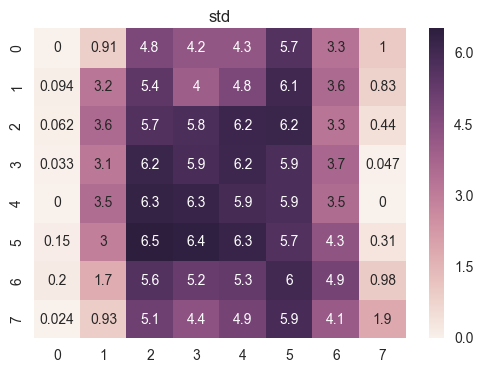

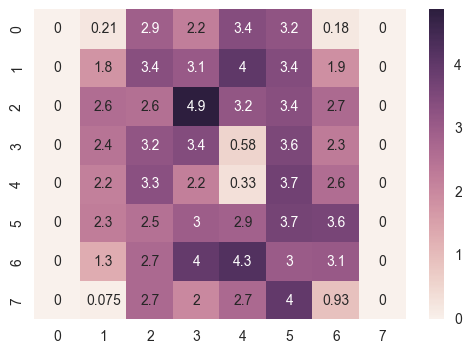

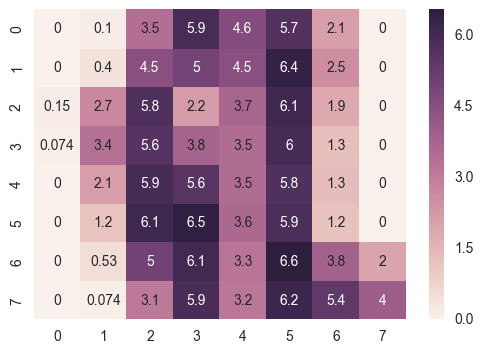

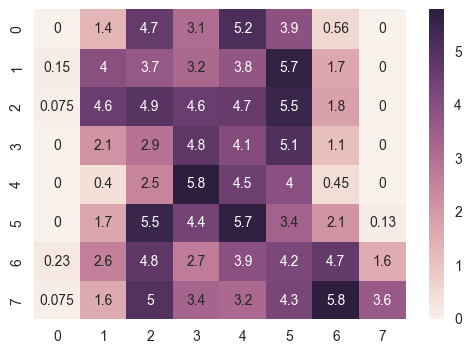

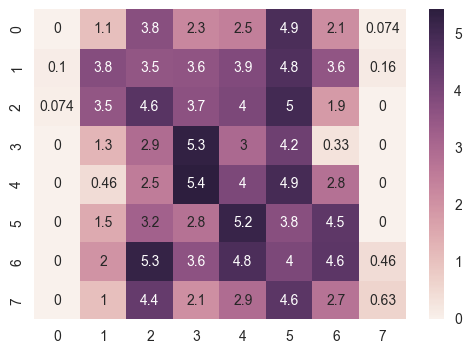

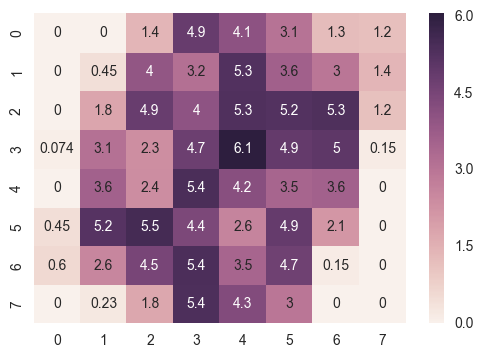

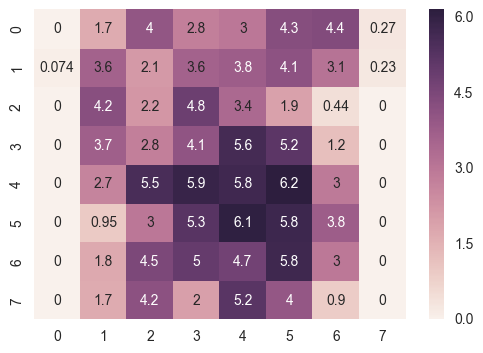

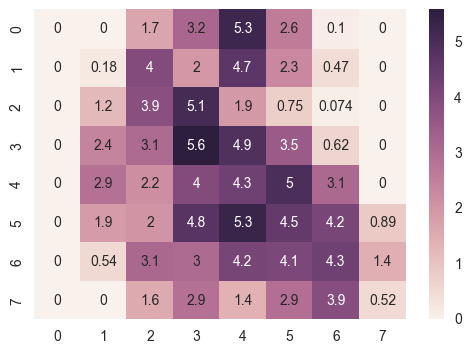

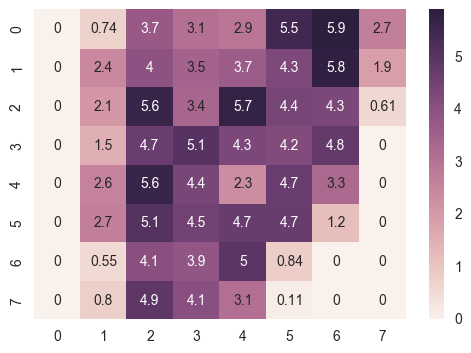

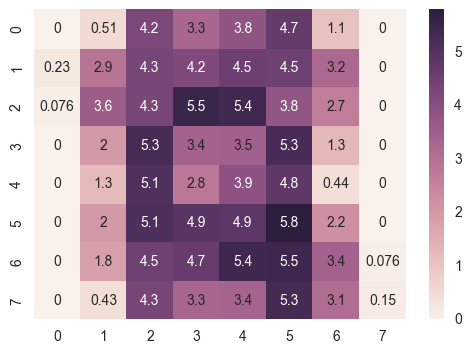

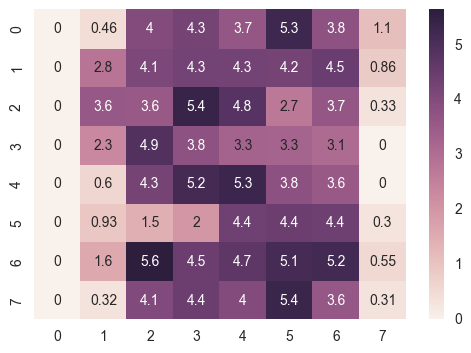

In [98]:
#std
std_heatmap = pd.DataFrame(des_data_frame_digits.iloc[2].reshape(8,8))
sns.heatmap(std_heatmap, annot=True)
plt.title("std")
#bonus
heatmap_group = data_frame_digits.groupby(digits.target).describe()
fig, ax = plt.subplots()
x=2
for d in range(10):   
    std_group_resh = heatmap_group.iloc[x].reshape(8,8)
    ax = sns.heatmap(std_group_resh, annot=True)
    x=x+8
    plt.show()

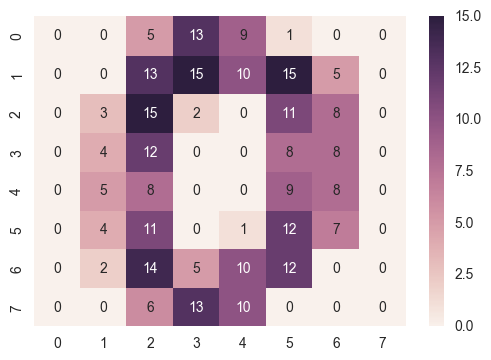

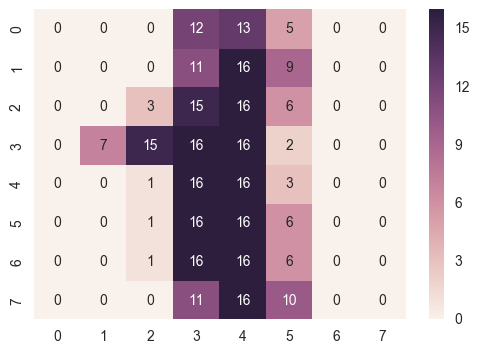

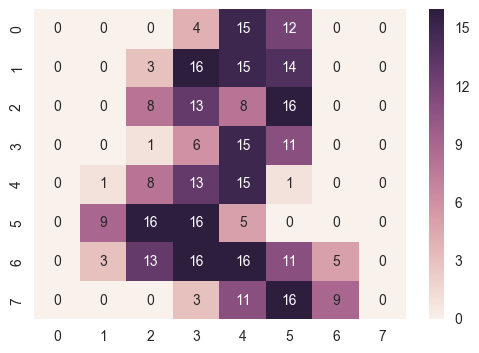

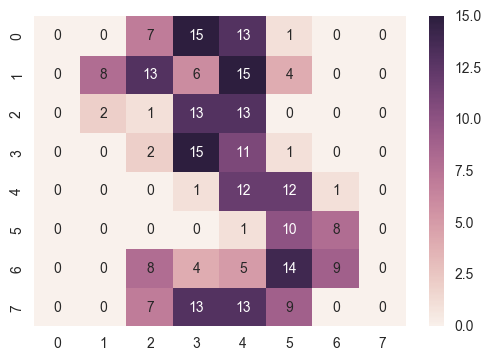

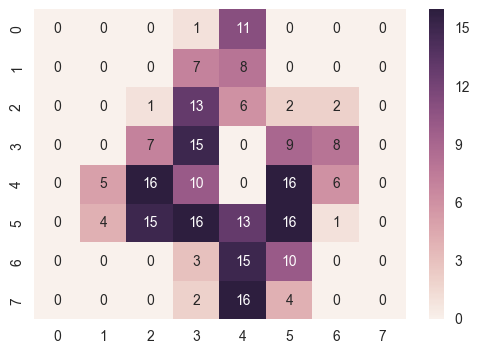

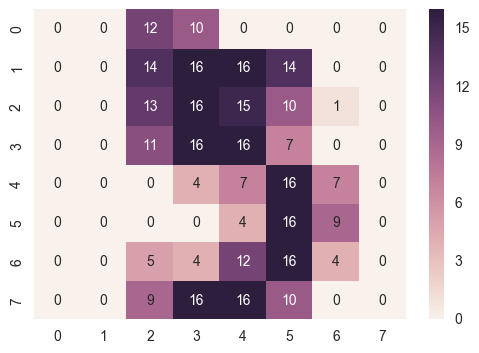

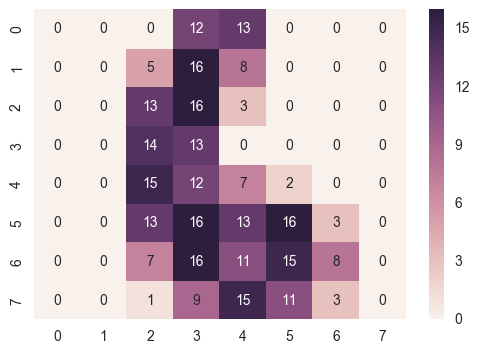

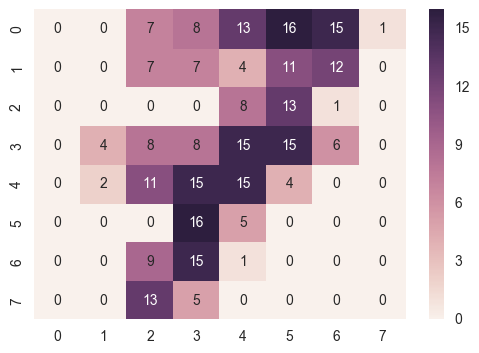

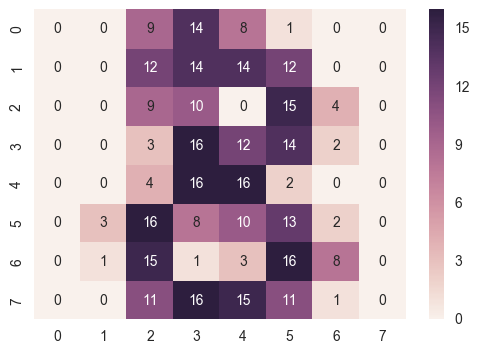

In [101]:
for i in range(9):
    HM_nine = pd.DataFrame(data_frame_digits.iloc[i].reshape(8,8))
    fig, ax = plt.subplots()
    ax = sns.heatmap(HM_nine, annot=True)
    plt.show

Not all of the dimensions going to be equally helpful for modelling. From the heat maps above we cuold see that there are many zeros in dim 0 and 7,so I am assuming these dim could be removed safely cause they dont vary at all. 

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

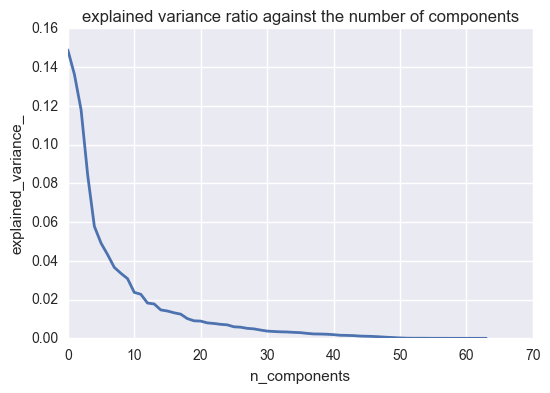

In [102]:
new_pca = PCA(n_components = digits.data.shape[1])
new_pca.fit(digits.data)
plt.plot(new_pca.explained_variance_ratio_, linewidth=2)
plt.title('explained variance ratio against the number of components')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

The point where 95% of the variance has been explained is:  28


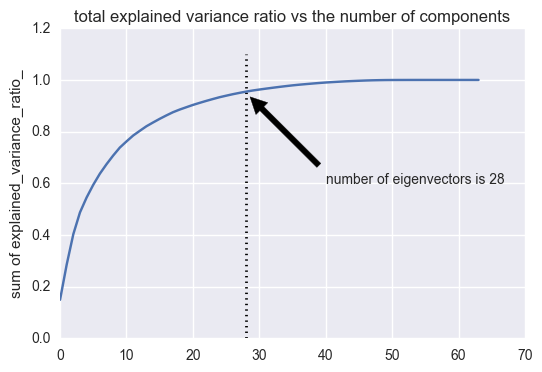

In [104]:
sum_variance = np.cumsum(new_pca.explained_variance_ratio_)
for i in range(64):
    if(sum_variance[i] >= 0.95):
        x_95 = i
        break
print('The point where 95% of the variance has been explained is: ', x_95)
plt.plot(sum_variance)
plt.vlines(x_95, 0, 1.1, linestyles='dotted', linewidths=2)
plt.title('total explained variance ratio vs the number of components')
plt.ylabel('sum of explained_variance_ratio_') 
plt.annotate('number of eigenvectors is {0}'.format(x_95), xy=(x_95, 0.95), 
             xytext=(40, 0.6), arrowprops=dict(facecolor='black', shrink=0.05))

the explained variace ratio got 95 when number of eigenvectors is 28,which means we could use less dimensionalities achieve the same task.

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

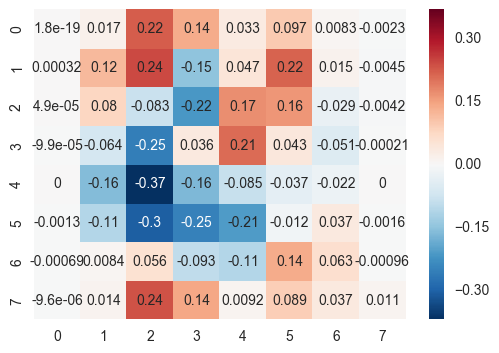

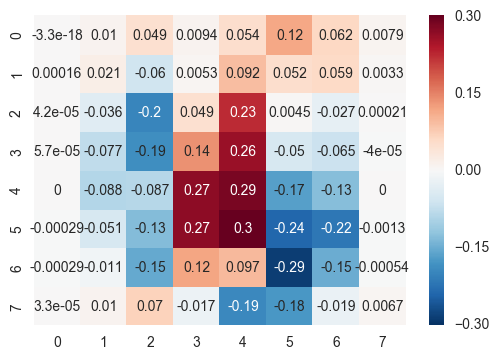

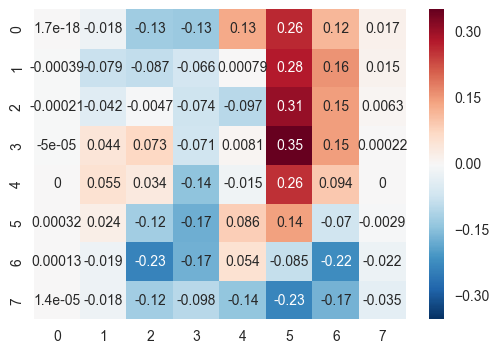

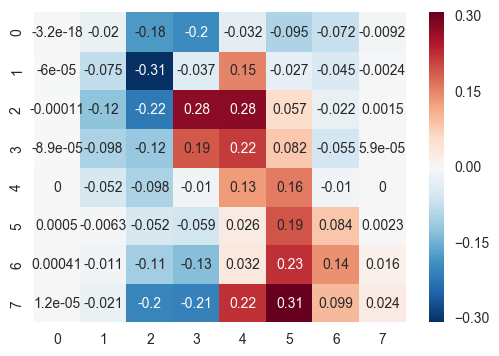

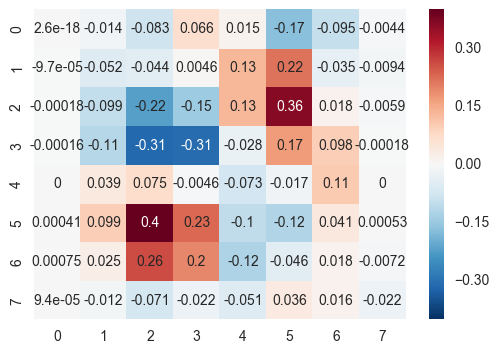

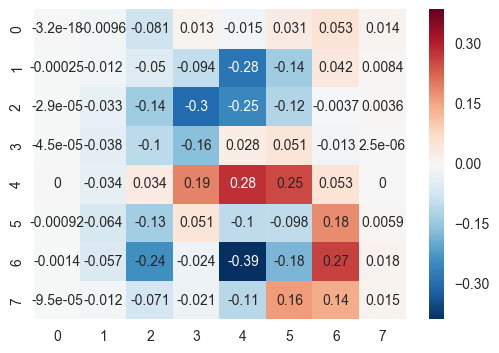

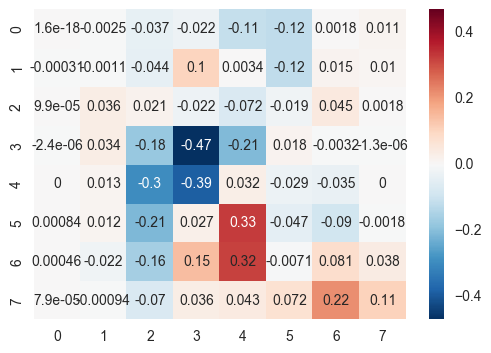

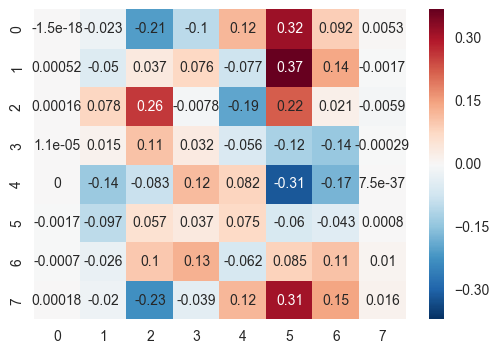

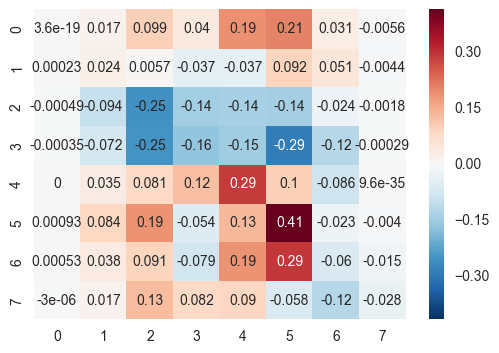

In [105]:
EG=new_pca.components_
for i in range(9):
    HM_nine = pd.DataFrame(EG[i].reshape(8,8))
    fig, ax = plt.subplots()
    ax = sns.heatmap(HM_nine, annot=True)
    plt.show

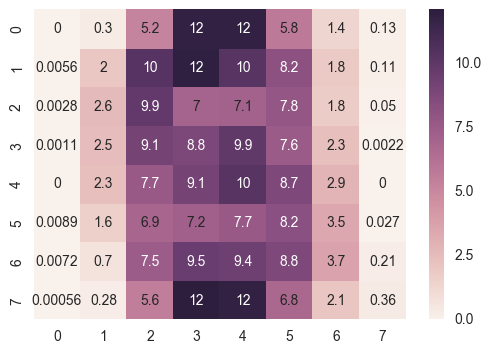

In [106]:
new_pca_mean = new_pca.mean_.reshape(8,8)
sns.heatmap(new_pca_mean, annot=True)

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

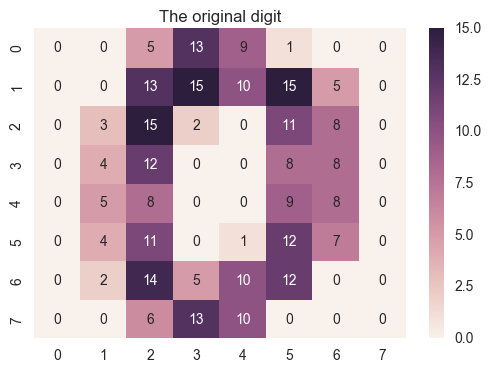

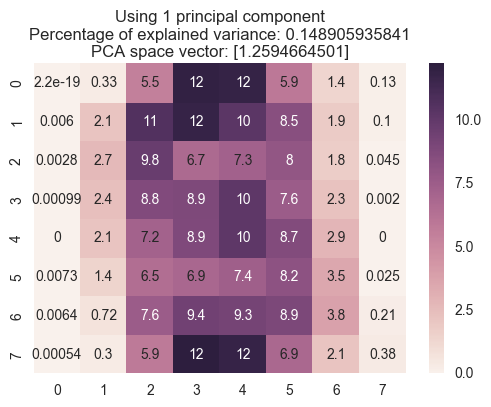

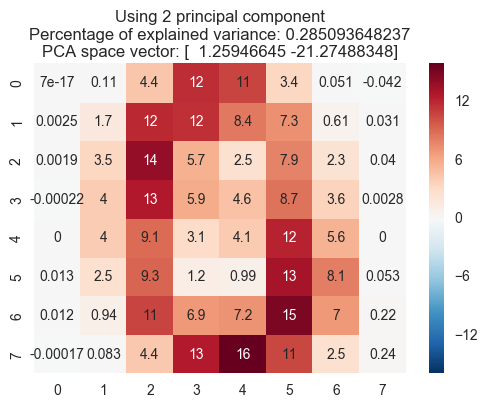

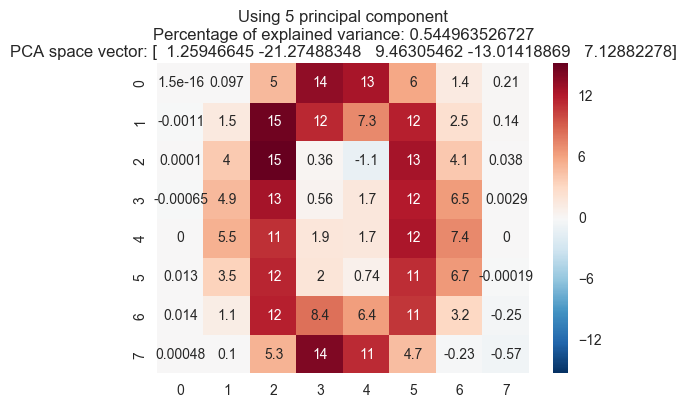

In [118]:
idx=0
coe=new_pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()
# The original digit
digit_idx = digits.data[idx,:].reshape(8,8)
ax = sns.heatmap(digit_idx, annot=True)
plt.title('The original digit')
plt.show()
# The digit reconstructed using 1 principal component
digit_idx_1 = (EG[0] * coe[0]).reshape(8,8) + new_pca_mean
ax = sns.heatmap(digit_idx_1, annot=True)
plt.title('Using 1 principal component\nPercentage of explained variance: {0}\nPCA space vector: [{1}]'.format(sum_variance[0],coe[0]))
plt.show()

# The digit reconstructed using 2 principal component
digit_idx_2 = (EG[0]*coe[0] + EG[1]*coe[1]).reshape(8,8) + new_pca_mean
ax = sns.heatmap(digit_idx_2, annot=True)
plt.title('Using 2 principal component\nPercentage of explained variance: {0}\nPCA space vector: {1}'.format(sum_variance[1],coe[0:2]))
plt.show()
#5 prin compon
coe_sum = np.zeros((64))
for i in range(5):
    coe_sum += EG[i] * coe[i]
digit_idx_5 = coe_sum.reshape(8,8) + new_pca_mean
ax = sns.heatmap(digit_idx_5, annot=True)
plt.title('Using 5 principal component\nPercentage of explained variance: {0}\nPCA space vector: {1}'.format(sum_variance[4],coe[0:5]))
plt.show()

Yes, eigenvectors produce realistic data. When principal component is increasing, the quality is becoming better. We could see that when principal component is 1, the heatmap is a mess, but when the principal component is larger, it looks better and looks more likey to the origanl digit. 

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [133]:
kf = KFold(len(digits.data), n_folds=5)
X_pca = new_pca.fit_transform(digits.data)
X = digits.data
y = digits.target
svc_1, svc_2, gnb_1, gnb_2 = [],[],[],[]
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    X_pca_train, X_pca_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svc1 = SVC(kernel='linear', shrinking=False, random_state=1337).fit(X_train, y_train)
    svc_1.append(svc1.score(X_test, y_test))
    
    svc2 = SVC(kernel='linear', shrinking=False, random_state=1337).fit(X_pca_train, y_train)
    svc_2.append(svc2.score(X_pca_test, y_test))
    
    gnb1 = GaussianNB().fit(X_train, y_train)
    gnb_1.append(gnb1.score(X_test, y_test))
    
    gnb2 = GaussianNB().fit(X_pca_train, y_train)
    gnb_2.append(gnb2.score(X_pca_test, y_test))

print ('Mean for:\nSVC 1: {0}\nSVC 2: {1}\nGussian 1: {2}\nGussian 2: {3}'.
       format(np.mean(svc_1), np.mean(svc_2), np.mean(gnb_1), np.mean(gnb_2)))

Mean for:
SVC 1: 0.948809965955
SVC 2: 0.948809965955
Gussian 1: 0.811934385639
Gussian 2: 0.836949860724


SVC did not imporve the performance, becuase we used SVC with linear kernel(which does not suitable for image classification) and the principal component it used was 64.
GaussianNB improved the performance by using pac, because pac reduced the dimensionalities, and this reduction could apply to GaussianNB, and improve the accuracy. 